# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://github.com/UBC-CS/cpsc330-2022W2/tree/main/lectures) 

**Due date: Monday Jan 23, 2023 at 11:59pm**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

## Instructions
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). In particular, **see the note about not pushing downloaded data to your repo**.

You are allowed to work and submit in pairs in this homework assignment. 

## Introducing the data set
 
For this  assignment you'll be looking at Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/) dataset.
The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

## Exercise 1: Exploratory data analysis

#### 1(a) 
rubric={points:2}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index. **Note:** you may need to change the name of the file if it does not match the download.

In [2]:
spotify_df = pd.read_csv("spotify.csv", index_col=0)

Excluding the target, how many columns (potential features) does the dataset include?

In [3]:
len(spotify_df.columns) - 1

15

**Ans:** 15

#### 1(b)
rubric={points:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [4]:
df_train, df_test = train_test_split(spotify_df, test_size=0.2, random_state=321)
print(f"num of train examples: {len(df_train)}")
print(f"num of test examples: {len(df_test)}")

num of train examples: 1613
num of test examples: 404


Training Examples: 1613
Test Examples: 404

#### 1(c)
rubric={points:3}

- Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
- Which feature has the largest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

Note that `describe` returns another DataFrame.

In [5]:
df_train.describe().loc['max'] - df_train.describe().loc['min']
# duration has largest range

acousticness             0.993997
danceability             0.836000
duration_ms         988585.000000
energy                   0.981400
instrumentalness         0.976000
key                     11.000000
liveness                 0.950200
loudness                30.364000
mode                     1.000000
speechiness              0.598900
tempo                  171.472000
time_signature           4.000000
valence                  0.936700
target                   1.000000
dtype: float64

**Ans:** duration has the largest range with a range of 988585


#### 1(d) 
rubric={points:5}

Let's focus on the following features:

- danceability
- tempo
- energy
- valence

For each of these features (in order), produce a histogram that shows the distribution of the feature values in the training set, **separated for positive and negative examples**. 
By "positive examples" we mean target = 1 (user liked the song, positive sentiment) and by "negative examples" we mean target = 0 (used disliked the song, negative sentiment). As an example, here is what the histogram would look like for a different feature, loudness:



<img src='loudness.png' width="400">

(You don't have to match all the details exactly, such as colour, but your histograms should look something like this, with a reasonable number of bins to see the shape of the distribution.) As shown above, there are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram above shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of the loop, which draws the figure and resets the canvas for your next plot.

Here is some code that separates out the dataset into positive and negative examples, to help you get started:

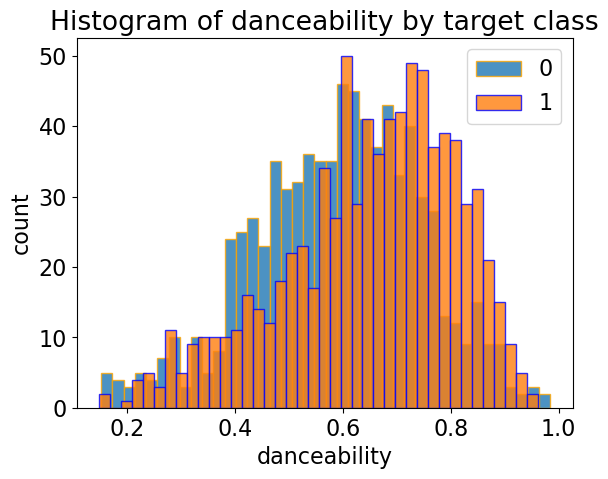

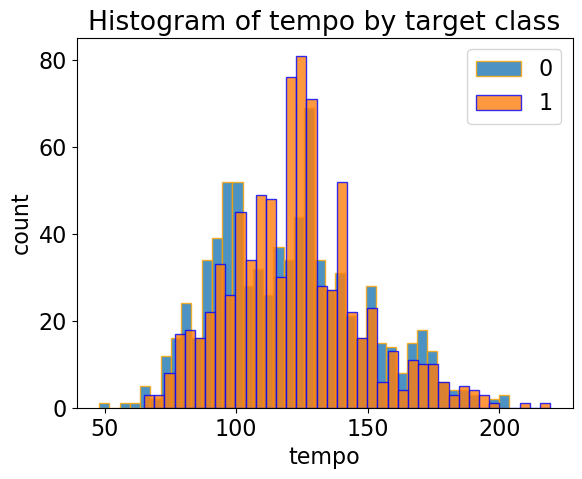

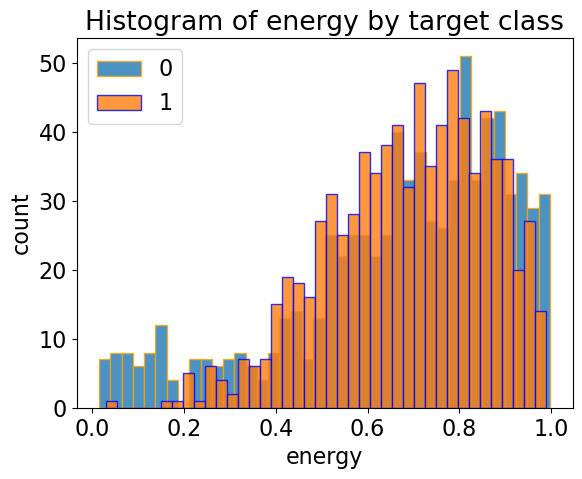

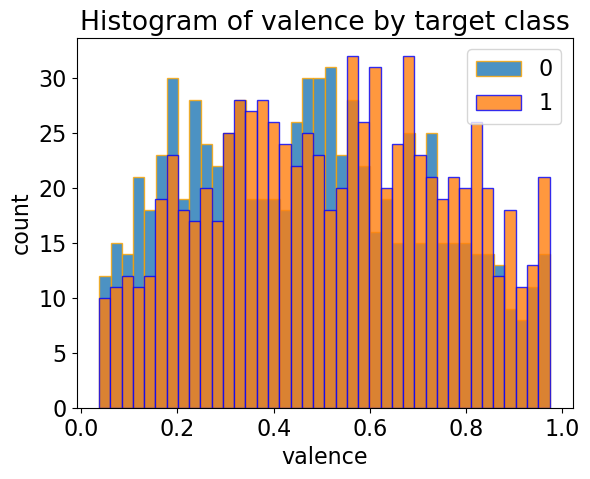

In [6]:
negative_examples = df_train.query("target == 0")
positive_examples = df_train.query("target == 1")

columns = ['danceability', 'tempo', 'energy', 'valence']

for i in range(0, 4):
    feature = columns[i]
    
    x = negative_examples[feature]
    y = positive_examples[feature]
    plt.hist(x, label='0', alpha=.8, edgecolor='orange', bins=40)
    plt.hist(y, label='1', alpha=.8, edgecolor='blue', bins=40)
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.legend()
    plt.title("Histogram of " + feature + " by target class")
    plt.show();

#### 1(e)
rubric={points:4}

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

**ANS:** A reasonable split would be to predict 0 if energy < 0.3 (and predict 1 otherwise)
I chose this as it is a feature which has a greater difference in separation between the negative and positive example. For the other features, their distributions overlap more, making it harder to determine the threshold.

#### 1(f)
rubric={points:2}

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?



**ANS:** Yes, as there's no differentiation between the classes that would infer one result over another **

#### 1(g) 
rubric={points:2}

Note that the dataset includes two free text features labeled `song_title` and `artist`:

In [7]:
df_train[["song_title", "artist"]].head()

,song_title,artist
260,WTF (Where They From) [feat. Pharrell Williams],Missy Elliott
1286,"10,000 Reasons (Bless the Lord) [Radio Version]",Matt Redman
1344,American Dream,Chelsea Grin
1197,Feel This Moment,Pitbull
119,Trap Queen,Fetty Wap


- Do you think these features could be useful in predicting whether the user liked the song or not? 
- Would there be any difficulty in using them in your model?   

**ANS:** These features could be useful to determine what specific songs the user like. However for a decision tree, they're not very useful as they are just string names that can't really be modeled. Since they are all distinct string values, it would be difficult to use them in your model. There doesn't appear to be any trend or threshold that we can infer from.

<br><br>

## Exercise 2: Using sklearn to build a decision tree classifier

#### 2(a) 
rubric={points:2}

- Create `X_train` and `y_train` and `X_test` and `y_test` from `df_train` and `df_test` above. Skip the `song_title` and `artist` features for now. 
- Fit a `DecisionTreeClassifier` on the train set.

In [8]:
X_train = df_train.drop(columns=["target", "song_title", "artist"], axis=1)
X_test = df_test.drop(columns=["target", "song_title", "artist"], axis=1)
y_train = df_train["target"]
y_test = df_test["target"]
model = DecisionTreeClassifier(random_state=100)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=100)

#### 2(b)
rubric={points:2}

Use the `predict` method to predict the class of the tenth example in your `X_train`. Is the prediction correct? That is, does it match with the corresponding class in `y_train`?  

> Hint: you can grab the tenth example with `X_train.iloc[[9]]`.

In [9]:
# model.predict(X_train.iloc[[9]])
# y_train[[9]]
print(f"prediction: {model.predict(X_train.iloc[[9]])}")
print(f"actual: {y_train[[9]]}")

prediction: [1]
actual: 9    1
Name: target, dtype: int64


Yes the prediction is correct, they are both equal to 1

#### 2(c) 
rubric={points:2}

Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. 

In [10]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10).mean()
cv_scores

0.6770646422820337

#### 2(d)
rubric={points:2}

The above is useful, but we would like to see the training accuracy as well. 

- Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True`. 
- Print out both the cross-validation score and the training score.
- Is your cross-validation score exactly the same as what you got in the previous part? Very briefly discuss.

In [11]:
cross_scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
# print(cross_scores)
# cross_scores['test_score'].mean()
print(f"cross validation score: \n {cross_scores['test_score'].mean()}")
print(f"training score: \n {cross_scores['train_score'].mean()}")

cross validation score: 
 0.6770646422820337
training score: 
 0.9988978817686291


**ANS:** The cross validation score is the same as the previous part since the random state is set to a fixed value of 100. This makes the random permutation of features at each split consistent. 

#### 2(e)
rubric={points:1}

Do you see a significant difference between the training score and the cross-validation score? Briefly discuss.

**ANS:** The cross-validation score is lower than the training score by about 0.2 which is a significant difference. This is because the model is fit on the training data, so the validation data is not seen by the model. Since the training score is also greater than the cross-validation score, this means there is overfitting. This means that the model is too complex or has high variance of data.

#### 2(f)
rubric={points:1}

Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your cross validation score?

In [12]:
cross_scores

{'fit_time': array([0.05387163, 0.03660297, 0.03419232, 0.03480411, 0.03501248,
        0.02167654, 0.02311993, 0.03014207, 0.0429194 , 0.04849172]),
 'score_time': array([0.00689936, 0.00392747, 0.00494885, 0.0047915 , 0.0027492 ,
        0.00308442, 0.00203276, 0.00099802, 0.00613332, 0.00680733]),
 'test_score': array([0.66666667, 0.60493827, 0.65432099, 0.71428571, 0.7515528 ,
        0.59627329, 0.70186335, 0.73291925, 0.64596273, 0.70186335]),
 'train_score': array([0.99931082, 0.99862164, 0.99931082, 0.99862259, 0.99862259,
        0.99862259, 0.99862259, 0.99931129, 0.99931129, 0.99862259])}

**ANS:** The values are all very similar to one another with minimal difference, which informs the trustworthiness as this means that the model isn't over or under performing with luck on bad randomization.

## Exercise 3: Hyperparameters 
rubric={points:10}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

- Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25).
- For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
- Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.
- Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth? 
- Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

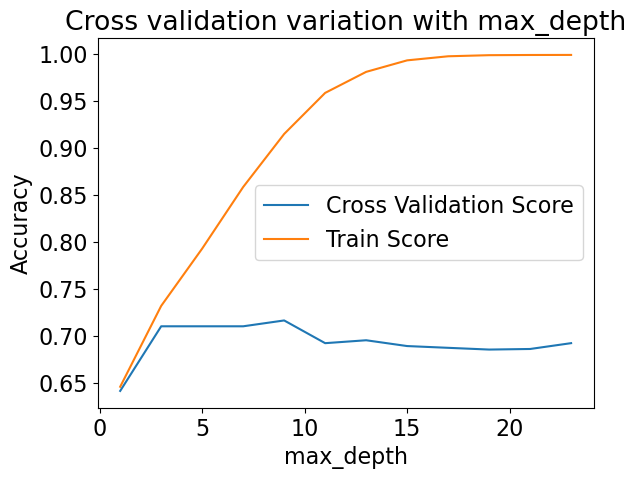

In [13]:
# Adapted from lecture 3
scores_crossval, scores_train = list(), list()
max_depth_list = range(1, 25, 2)
for maxdepth in max_depth_list:
    maxdepth = DecisionTreeClassifier(max_depth=maxdepth)
    scores = cross_validate(maxdepth, X_train, y_train, cv=10, return_train_score=True)
    
    scores_crossval.append(scores["test_score"].mean())
    scores_train.append(scores["train_score"].mean())

plt.plot(max_depth_list, scores_crossval, label="Cross Validation Score")
plt.plot(max_depth_list, scores_train, label="Train Score")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

plt.title('Cross validation variation with max_depth')

plt.legend()

- Discuss how changing the max_depth hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth?
- Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

**ANS:** As the max_depth increases, the cross val score initially increases at the same rate as the train score, but after a max_depth of 3 the train score becomes much greater than the cross val score. 
From these results, I would pick a max_depth of 5 as this is the "sweet spot" before over and underfitting. This depth was chosen as it would minimize the cross-validation error. I believe that the depth I chose would generalize to other spotify datasets, as I assume they would have the same distribution.

## Exercise 4: Test set
rubric={points:4}

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy.

- Select your favorite max_depth from the previous part.
- Train a decision tree classifier using that max_depth on the entire training set.
- Compute and display the test score.
- How does it compare to the cross-validation score from the previous exercise? Briefly discuss.

In [14]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
print(f"test score: {model.score(X_test, y_test)}")

test score: 0.7054455445544554


**ANS:** The test score at a chosen max_depth of 5 is 0.705. Compared to the previous cross-validation score (0.712), this score is only slightly lower. This is because it is the max_depth at which the cross validation error is minimized, and would give more accurate results. However since the cross validate and training error are high, the model may be overfit.

## Exercise 5: Conceptual questions
rubric={points:3}

Consider the dataset below, which has $6$ examples and $2$ features:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\-1\\-1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

**ANS:**
1. The true case would be that y = -1, while the false case would be y = +1
2. The training accuracy would be 5/6 (83%)
3. No, there is no one feature that would enable a 100% accuracy prediction by only using equality operators.

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 